# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>


### Introduction

In this notebook we will try to calculate the ground state wavefunction end energy of of a single quantum particle in a one dimensional space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

Since there is no analytic solution of a potential of this kind, we will try to solve the problem by mean of numerical methods.

First we will show an approximate discretized way of solving the problem, so that we have a first solution that we will later confront with the one found by a Variational Monte Carlo method.

### Discretized Schrödinger equation

This method consists in setting up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ becomes a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

Now we notice that a discretized second derivative can be written in the following way: 

$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

Then the time independent Schrodinger equation becomes from this:

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

to this:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the Schrodinger equation we have just to find eigenstates and eigenvalues of this matrix; below we see this done by a python program.

Ground state energy:  -0.46046587969271546
1st excited state energy:  0.09742471331761013
2nd excited state energy:  1.9717331343930202


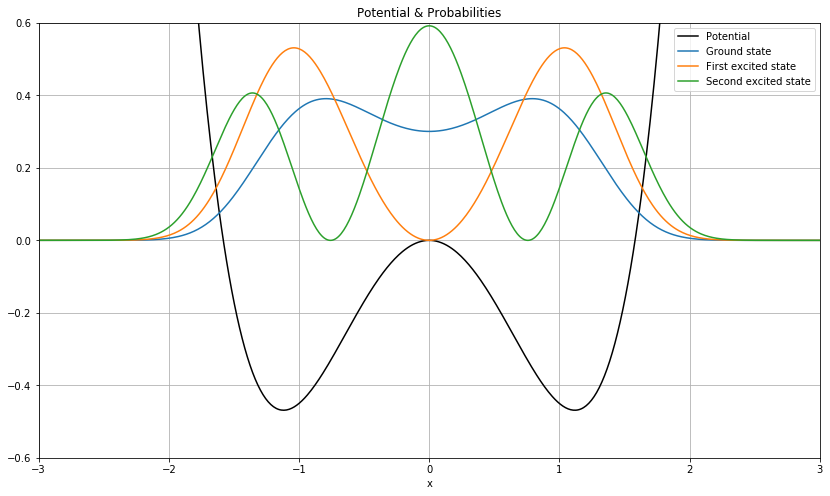

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10 #Range da -5 a +5
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

###########################
#mu=0.75
#sig=0.6
#psi_mia=np.exp(-(x-mu)*(x-mu)/(sig*sig))+np.exp(-(x+mu)*(x+mu)/(sig*sig))+2*np.exp(-(x*x+mu*mu)/(sig*sig))
###########################

# Plot a few things
plt.figure(figsize=(14,8))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2,label="Ground state")
plt.plot(x,(psi[1])**2,label="First excited state")
plt.plot(x,(psi[2])**2,label="Second excited state")
plt.legend()
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
#plt.ylim((-0.6,3))
plt.show()

### <font color="red">Exercise 08.1: Variational Monte Carlo, first trial <font>

Now we write a C++ Variational Monte Carlo for solving the problem. The idea, at this step, is to simply sample a a trial wave function $|\Psi_T(x)|^2$ using the Metropolis alorithm with an uniform transition probability $T(x_{new}|x_{old})$. 

Then, since acting with the Hamiltonian on our trial wavefunction is just a matter of working out a second derivative, we can compute the expectation value for the Hamiltonian on our trial state by sampling points following the probability ditribution $|\Psi_T(x)|^2$ (we use data blocking just as usually):

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

In this way we set an upper bound to the ground state energy.

We will use the following sum of two gaussian as trial wave function:

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters, $\sigma$, the width of the two Gaussians under square root, and $\mu$, the distance from the origin of their average values.

In this first case we use as parameters: $\mu=0,80$, $\sigma=0,6$.

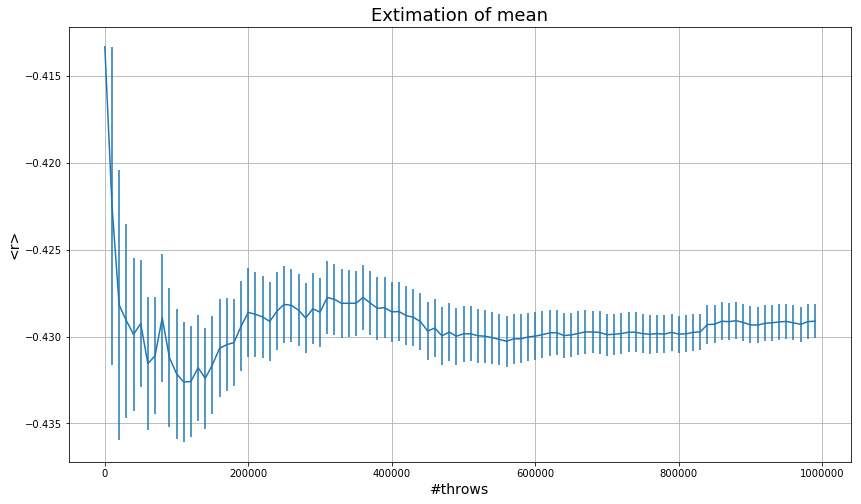

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

M=1000000             # Total number of throws
N=100                 # Number of blocks
L=int(M/N)            # Number of throws in each block, please use for M a multiple of N


x_altro = np.arange(N)      # [0,1,2,...,N-1]

sum_prog, err_prog = np.loadtxt("./8.1/Energy.dat", usecols=(0,1), delimiter=' ', unpack='true')    
    
x_altro*=L # Number of throws = block * (Number of throws in each block)
fig=plt.figure(figsize=(14, 8))
plt.errorbar(x_altro,sum_prog,yerr=err_prog)
plt.title('Extimation of mean', fontsize=18)
plt.xlabel('#throws', fontsize=14)
plt.ylabel('<r>', fontsize=14)
plt.grid(True)
plt.show()

### <font color="red">Exercise 08.2: Variational Monte Carlo, best parameters <font>

Now that we can compute the energy of different trial states in the same way as done in the previous point, we take the $\sigma$ and $\mu$ parameters from a grid of values and see, within the limit of the uncertainty of the energy, which set of parameters gives the best result. For us the best parameters are:

$$\sigma=0.62 \qquad \mu=0.79$$

At this point we show a picture of our estimation of $\langle {\hat H} \rangle_T$ </span> with this set of parameters, plotting as always its statistical uncertainty as a function of the number of blocks.

Later on we will confront the analytic curve of $|\Psi_T(x)|^2$ with the distribution we sampled through the Metropolis algorithm (we just fil a histogram with the sampled points) and with the $|\Psi_T(x)|^2$ given by our first numerical discrete approximation.

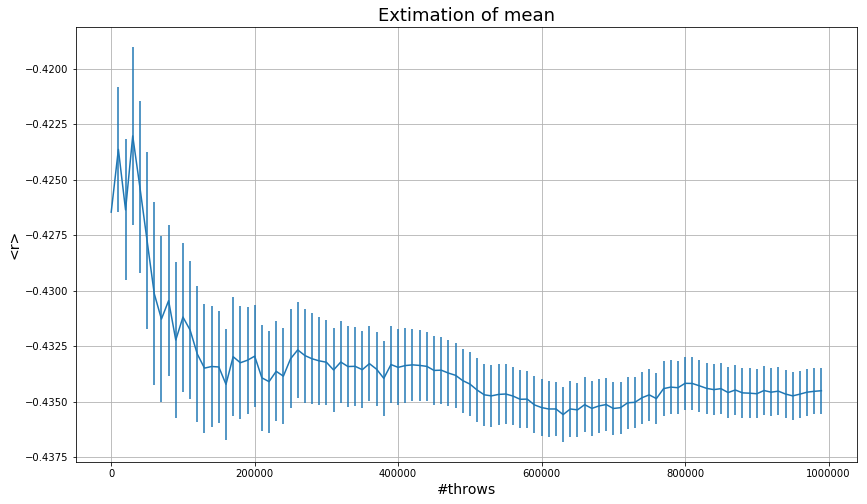

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

M=1000000             # Total number of throws
N=100                 # Number of blocks
L=int(M/N)            # Number of throws in each block, please use for M a multiple of N


x_altro = np.arange(N)      # [0,1,2,...,N-1]

sum_prog, err_prog = np.loadtxt("./8.2/Energy.dat", usecols=(0,1), delimiter=' ', unpack='true')    
    
x_altro*=L # Number of throws = block * (Number of throws in each block)
fig=plt.figure(figsize=(14, 8))
plt.errorbar(x_altro,sum_prog,yerr=err_prog)
plt.title('Extimation of mean', fontsize=18)
plt.xlabel('#throws', fontsize=14)
plt.ylabel('<r>', fontsize=14)
plt.grid(True)
plt.show()

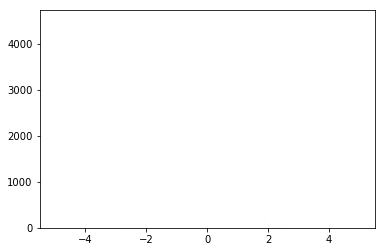

In [17]:
mu=0.79
sigma=0.62

psi_trial=np.exp(-(x-mu)*(x-mu)/(sigma*sigma))+np.exp(-(x+mu)*(x+mu)/(sigma*sigma))+2*np.exp(-(x*x+mu*mu)/(sigma*sigma))

raw= np.loadtxt("./8.2/Psi^2.dat", usecols=(0), delimiter=' ', unpack='true')
n, bins, patches = plt.hist(raw, 1000, (-5,+5), edgecolor='white', linewidth=1.2)
x_2=np.linspace(-5,+5,1000)
n=n/10000
psi_trial=psi_trial/2.8

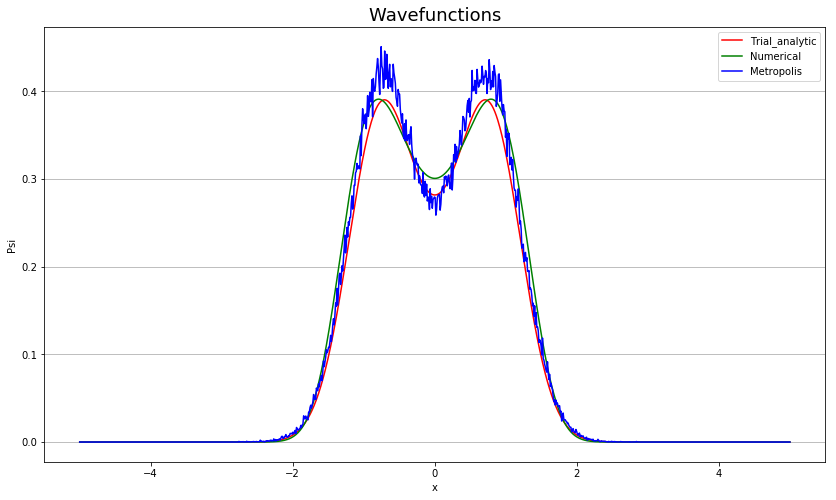

In [15]:
fig2=plt.figure(figsize=(14, 8))
plt.plot(x,psi_trial, color='r', label='Trial_analytic')
plt.plot(x,(psi[0])**2, color='g', label='Numerical')
plt.plot(x_2,n, color='b', label='Metropolis')
plt.legend()
plt.xlabel('x')
plt.ylabel('Psi')
plt.title('Wavefunctions',fontsize=18)
plt.grid(True, axis='y')

plt.show()

### <font color="red">Exercise 08.3: Path integral Monte Carlo <font>

To try another different approach we will use a code that has been provided to us and that can perform either a path integral Monte Carlo (PIMC) or path integral ground state (PIGS).

First we start with the PIGS to study the ground state of the system. We will represent the potential energy of the chain of states that compose the path integral: the states at the middle of the chain are those who resemble the most the ground state and thus will have minimum energy, the states at the endpoint are on the contrary more similar to the trial states. We represent the potential energy and the probability density (to be more precise the configurations sampled by the program) in two cases:
- a constant trial wave function, $\Psi_T(x)=1$
- our old double-gaussian trial wave function $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$ with optimized parameters $\sigma=0.62$, $\mu=0.79$.

We can note clearly that the potential energy decreases very much from the endpoint to the middle of the chain in the case of constant trial wave function, while in the case of the double-gaussian trial wavefunction the decreasing is very little, showing that our guess as trial wavefunction was close to the real ground state.

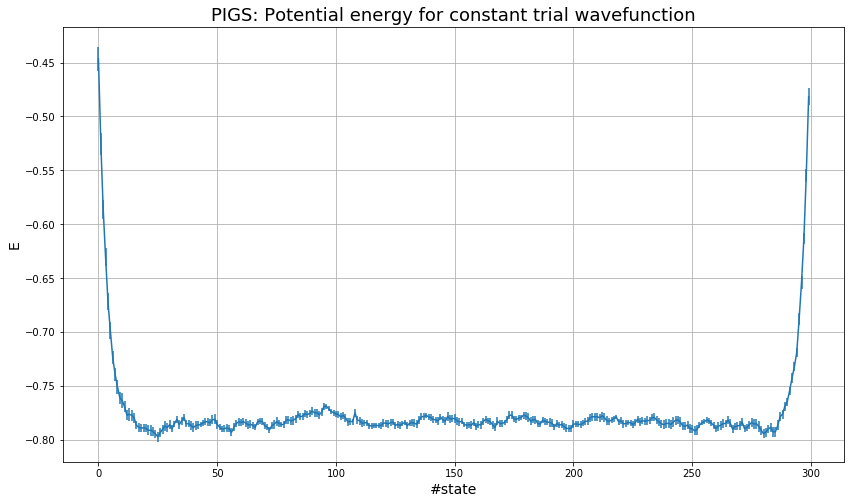

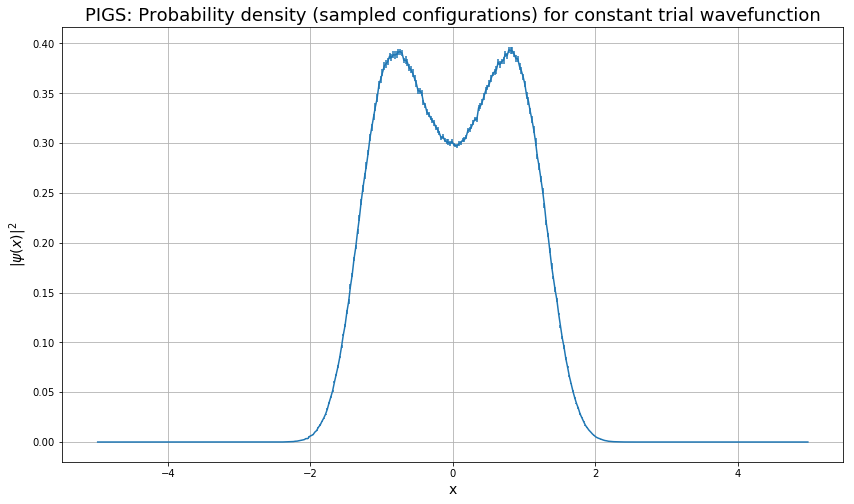

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

stati, energie, err_energie = np.loadtxt("./8.3/Data/constant_potential.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    
posizioni, psi, err_psi = np.loadtxt("./8.3/Data/constant_probability.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    
    
fig=plt.figure(figsize=(14, 8))
plt.errorbar(stati, energie,yerr=err_energie)
plt.title('PIGS: Potential energy for constant trial wavefunction', fontsize=18)
plt.xlabel('#state', fontsize=14)
plt.ylabel('E', fontsize=14)
plt.grid(True)

fig=plt.figure(figsize=(14, 8))
plt.errorbar(posizioni, psi,yerr=err_psi)
plt.title('PIGS: Probability density (sampled configurations) for constant trial wavefunction', fontsize=18)
plt.xlabel('x', fontsize=14)
plt.ylabel('$|\psi(x)|^2$', fontsize=14)
plt.grid(True)
plt.show()

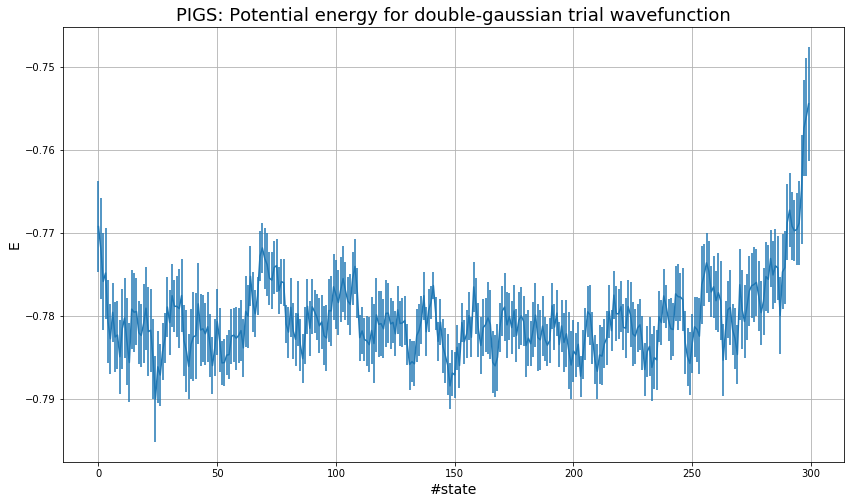

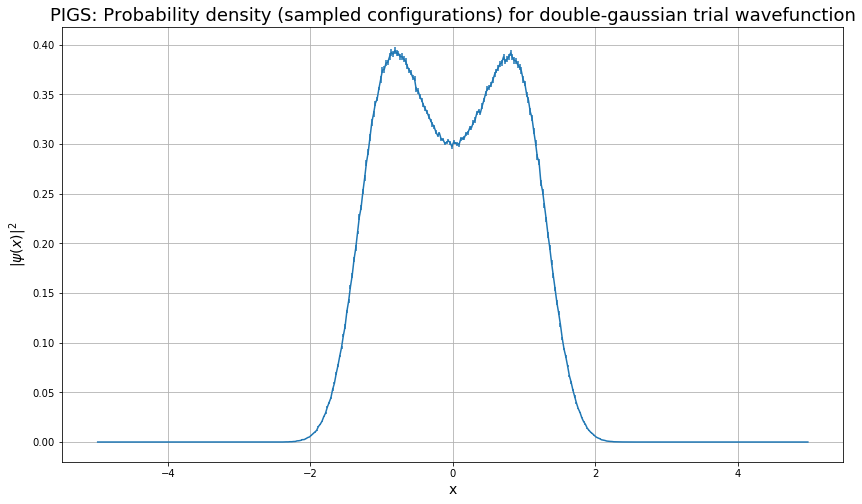

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

stati, energie, err_energie = np.loadtxt("./8.3/Data/trial_potential.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    
posizioni, psi, err_psi = np.loadtxt("./8.3/Data/trial_probability.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    
    
fig=plt.figure(figsize=(14, 8))
plt.errorbar(stati, energie,yerr=err_energie)
plt.title('PIGS: Potential energy for double-gaussian trial wavefunction', fontsize=18)
plt.xlabel('#state', fontsize=14)
plt.ylabel('E', fontsize=14)
plt.grid(True)

fig=plt.figure(figsize=(14, 8))
plt.errorbar(posizioni, psi,yerr=err_psi)
plt.title('PIGS: Probability density (sampled configurations) for double-gaussian trial wavefunction', fontsize=18)
plt.xlabel('x', fontsize=14)
plt.ylabel('$|\psi(x)|^2$', fontsize=14)
plt.grid(True)
plt.show()

### Energy

In both cases we can draw the total energy, obtaining a value in accordance with the previous one found by variational Monte Carlo code or by discrete approximation, however the errorbar are quite large, so it is difficult to estimate the ground state energy with precision as in the first two numerical methods.

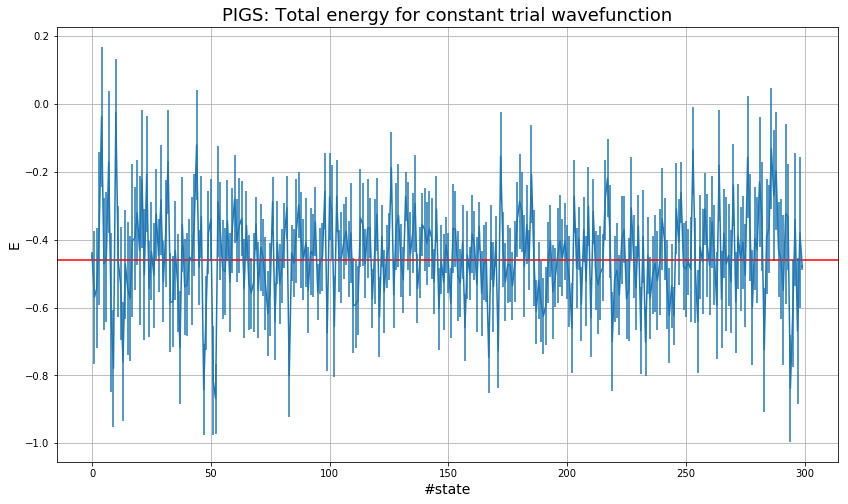

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

stati, energie, err_energie = np.loadtxt("./8.3/Data/constant_energy.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    

fig=plt.figure(figsize=(14, 8))
plt.errorbar(stati, energie,yerr=err_energie)
plt.title('PIGS: Total energy for constant trial wavefunction', fontsize=18)
plt.xlabel('#state', fontsize=14)
plt.ylabel('E', fontsize=14)
plt.axhline(y=-0.46046587969271546, color='r', linestyle='-')
plt.grid(True)
plt.show()

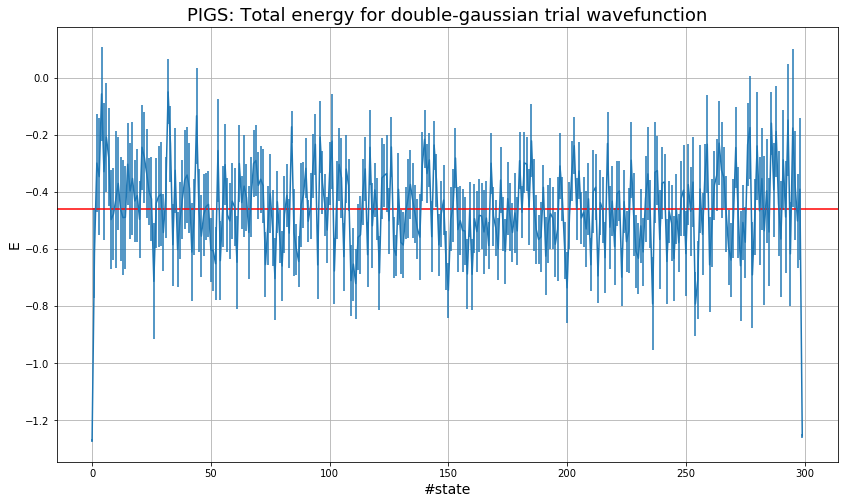

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

stati, energie, err_energie = np.loadtxt("./8.3/Data/trial_energy.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    

fig=plt.figure(figsize=(14, 8))
plt.errorbar(stati, energie,yerr=err_energie)
plt.title('PIGS: Total energy for double-gaussian trial wavefunction', fontsize=18)
plt.xlabel('#state', fontsize=14)
plt.ylabel('E', fontsize=14)
plt.axhline(y=-0.46046587969271546, color='r', linestyle='-')
plt.grid(True)
plt.show()

We see that reducing the imaginary time propagation in the constant trial wavefunction case from $8$ to $0.05$ gives bad results for the probability density, as shown below. Whereas the same imaginary time propagation number for the double-gaussian case works almost fine.

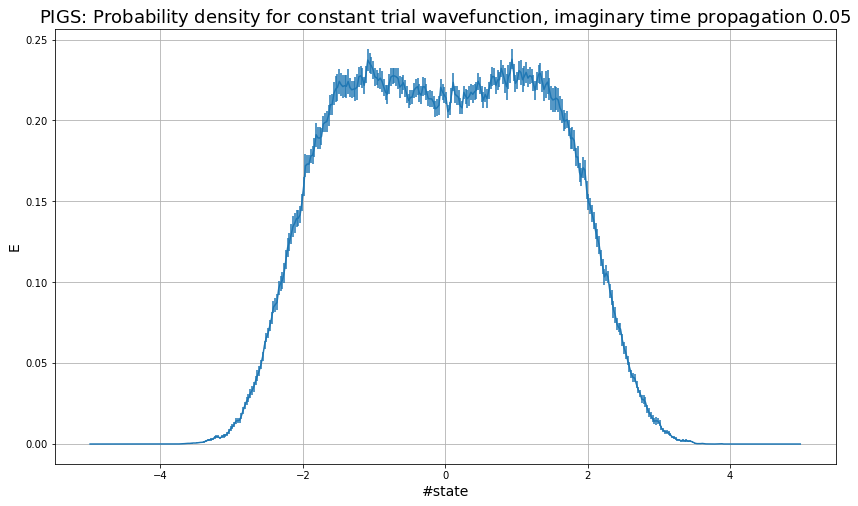

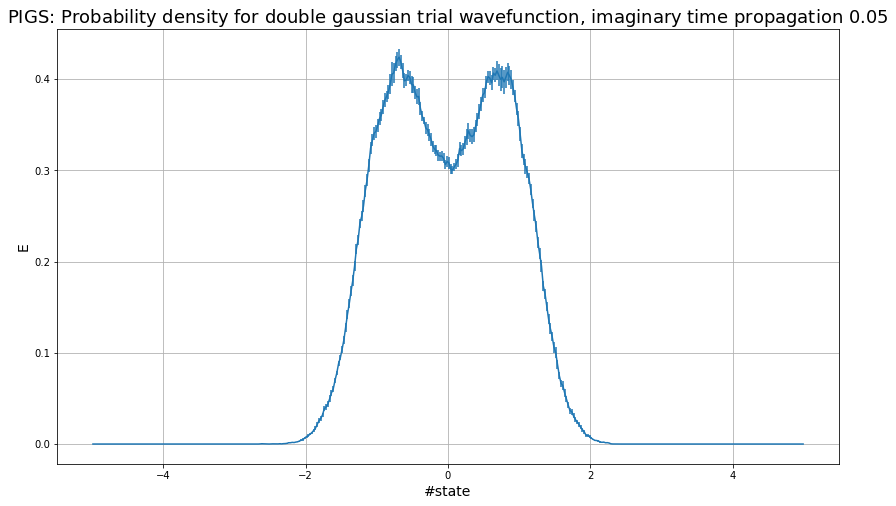

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

stati, energie, err_energie = np.loadtxt("./8.3/Data/constant_0.05_probability.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    

fig=plt.figure(figsize=(14, 8))
plt.errorbar(stati, energie,yerr=err_energie)
plt.title('PIGS: Probability density for constant trial wavefunction, imaginary time propagation $0.05$', fontsize=18)
plt.xlabel('#state', fontsize=14)
plt.ylabel('E', fontsize=14)
plt.grid(True)

stati, energie, err_energie = np.loadtxt("./8.3/Data/trial_0.05_probability.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    

fig=plt.figure(figsize=(14, 8))
plt.errorbar(stati, energie,yerr=err_energie)
plt.title('PIGS: Probability density for double gaussian trial wavefunction, imaginary time propagation $0.05$', fontsize=18)
plt.xlabel('#state', fontsize=14)
plt.ylabel('E', fontsize=14)
plt.grid(True)

plt.show()

At last, use the PIMC algorithm ($T>0$) to observe how the histogram with the sampled configurations changes by increasing the temperature.

The result is that, increasing the temperature, the system is not anymore frozen in the ground state and the contribution of other states becomes more and more relevant.

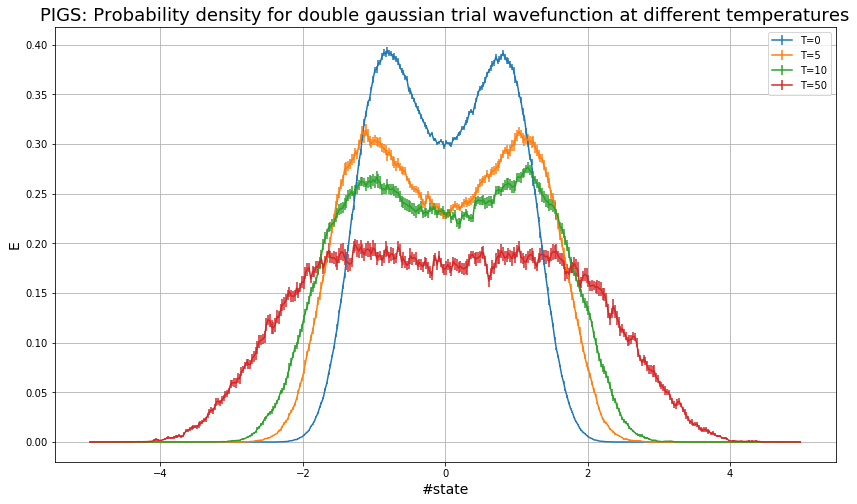

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

stati_0, energie_0, err_energie_0 = np.loadtxt("./8.3/Data/trial_probability.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    
stati_5, energie_5, err_energie_5 = np.loadtxt("./8.3/Data/probability_5.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    
stati_10, energie_10, err_energie_10 = np.loadtxt("./8.3/Data/probability_10.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    
stati_50, energie_50, err_energie_50 = np.loadtxt("./8.3/Data/probability_50.dat", usecols=(0,1,2), delimiter=' ', unpack='true')    

fig=plt.figure(figsize=(14, 8))
plt.errorbar(stati_0, energie_0,yerr=err_energie_0,label="T=0")
plt.errorbar(stati_5, energie_5,yerr=err_energie_5,label="T=5")
plt.errorbar(stati_10, energie_10,yerr=err_energie_10,label="T=10")
plt.errorbar(stati_50, energie_50,yerr=err_energie_50,label="T=50")

plt.title('PIGS: Probability density for double gaussian trial wavefunction at different temperatures', fontsize=18)
plt.xlabel('#state', fontsize=14)
plt.ylabel('E', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()